In [3]:
import SIMSIToolBox
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error
import random as rd
import seaborn as sb
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import spatial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.svm import SVR
cosineSim = lambda x1,x2: 1 - spatial.distance.cosine(x1, x2)
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
import statsmodels.api as sm
import sympy as sym
import pickle as pkl

In [4]:
#goal simulate labeling patterns

n=100
c13ab = 0.0 #natural abundance
numCarbons = 18
N = np.array([(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2]) #get expected labeling of precursor from natural abundance
exprList = SIMSIToolBox.generateISAExpressions(SIMSIToolBox.getISAEq(numCarbons),numCarbons)
isa_func = sym.lambdify(*exprList)

gs1 = np.random.random(n)
es1 = np.random.random(n)
os1 = np.random.random(n)
gs = gs1 / (gs1 + es1 + os1)
es = es1 / (gs1 + es1 + os1)
os = os1 / (gs1 + es1 + os1)
ds = .5 * np.random.random(n) + .5
ts = np.random.random((n,3)) + 0.2
ts = np.array([x/np.sum(x) for x in ts])


In [5]:
labeling_theo = []
for g,t,d,e,o in zip(gs,ts,ds,es,os):
    x = d * t + (1-d) * N
    labeling_theo.append(isa_func(x[0],x[1],x[2],N[0],N[1],N[2],g,o,e))
labeling_theo = np.array(labeling_theo)

In [6]:
plt_dict = {}

for noiseFrac in np.linspace(0.0,.5,15):
    for g,d,t,e,l_true in zip(gs,ds,ts,es,labeling_theo):
        x_true = d * np.array(t) + (1-d) * np.array(N)
        noise = np.random.random(l_true.shape)
        noise = noiseFrac * noise / np.sum(noise)
        l_obs = (1-noiseFrac) * l_true / np.sum(l_true)
        l_obs = [l+ns for l,ns in zip(l_obs,noise)]
        l_obs = np.array(l_obs)/np.sum(l_obs)
                
        err_measure = np.mean([np.abs(x-y) for x,y in zip(l_obs,l_true)])
        
        g_pred, e_pred,_, x_pred, err, l_pred = SIMSIToolBox.ISAFit_e_g([0,0,1],N,l_obs,exprList,list(range(len(l_obs))),np.array([0.33,0.33,0.33]))
        
        err_x = np.sum(np.abs(x_true-x_pred))
        err_g = np.abs(g_pred-g)
        err_e = np.abs(e_pred-e)
        err_total = np.abs(e + g - g_pred - e_pred)
                
        
        if g_pred > -.0001 and g_pred < 1.1 and all(xx > -0.01 and xx < 1.1 for xx in x_pred) and g_pred > -.0001 and g_pred < 1.1 and e_pred > -0.001 and e_pred < 1.1 :
            plt_dict[len(plt_dict)] = {"method":"SISA","error in g(t)":err_g,"err_total":err_total,"measurement error":err_measure,"error in acetyl-CoA":err_x,"error in e(t)":err_e,"fit_error":err}
        
plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
plt_dict = plt_dict.sort_values(by="measurement error")
plt_dict

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\SIMSIToolBox\__init__.py:818: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: objectiveFunc(P, func(x[3]/np.sum(x[3:6]),x[4]/np.sum(x[3:6]),x[5]/np.sum(x[3:6]),N[0],N[1],N[2],x[0]/np.sum(x[:3]),x[1]/np.sum(x[:3]),x[2]/np.sum(x[:3])), goodInd) + 0.001 * (x[0] + x[2])/np.sum(x[:3]),


,method,error in g(t),err_total,measurement error,error in acetyl-CoA,error in e(t),fit_error
74,SISA,0.002570,0.033036,0.000000,0.042326,0.030467,0.000744
66,SISA,0.000045,0.006619,0.000000,0.012960,0.006574,0.000597
25,SISA,0.006001,0.222695,0.000000,0.614732,0.216693,0.000584
65,SISA,0.009082,0.377598,0.000000,0.786317,0.368516,0.000760
61,SISA,0.000375,0.000719,0.000000,0.001280,0.000344,0.000901
...,...,...,...,...,...,...,...
1425,SISA,0.372029,0.100917,0.043792,0.101394,0.271112,0.011002
1445,SISA,0.405125,0.283621,0.044255,0.362138,0.121504,0.011848
1306,SISA,0.332678,0.411948,0.045283,0.714819,0.079269,0.013114
1422,SISA,0.382555,0.127077,0.047905,0.794386,0.509632,0.021162


err_total 0.40548823497540554


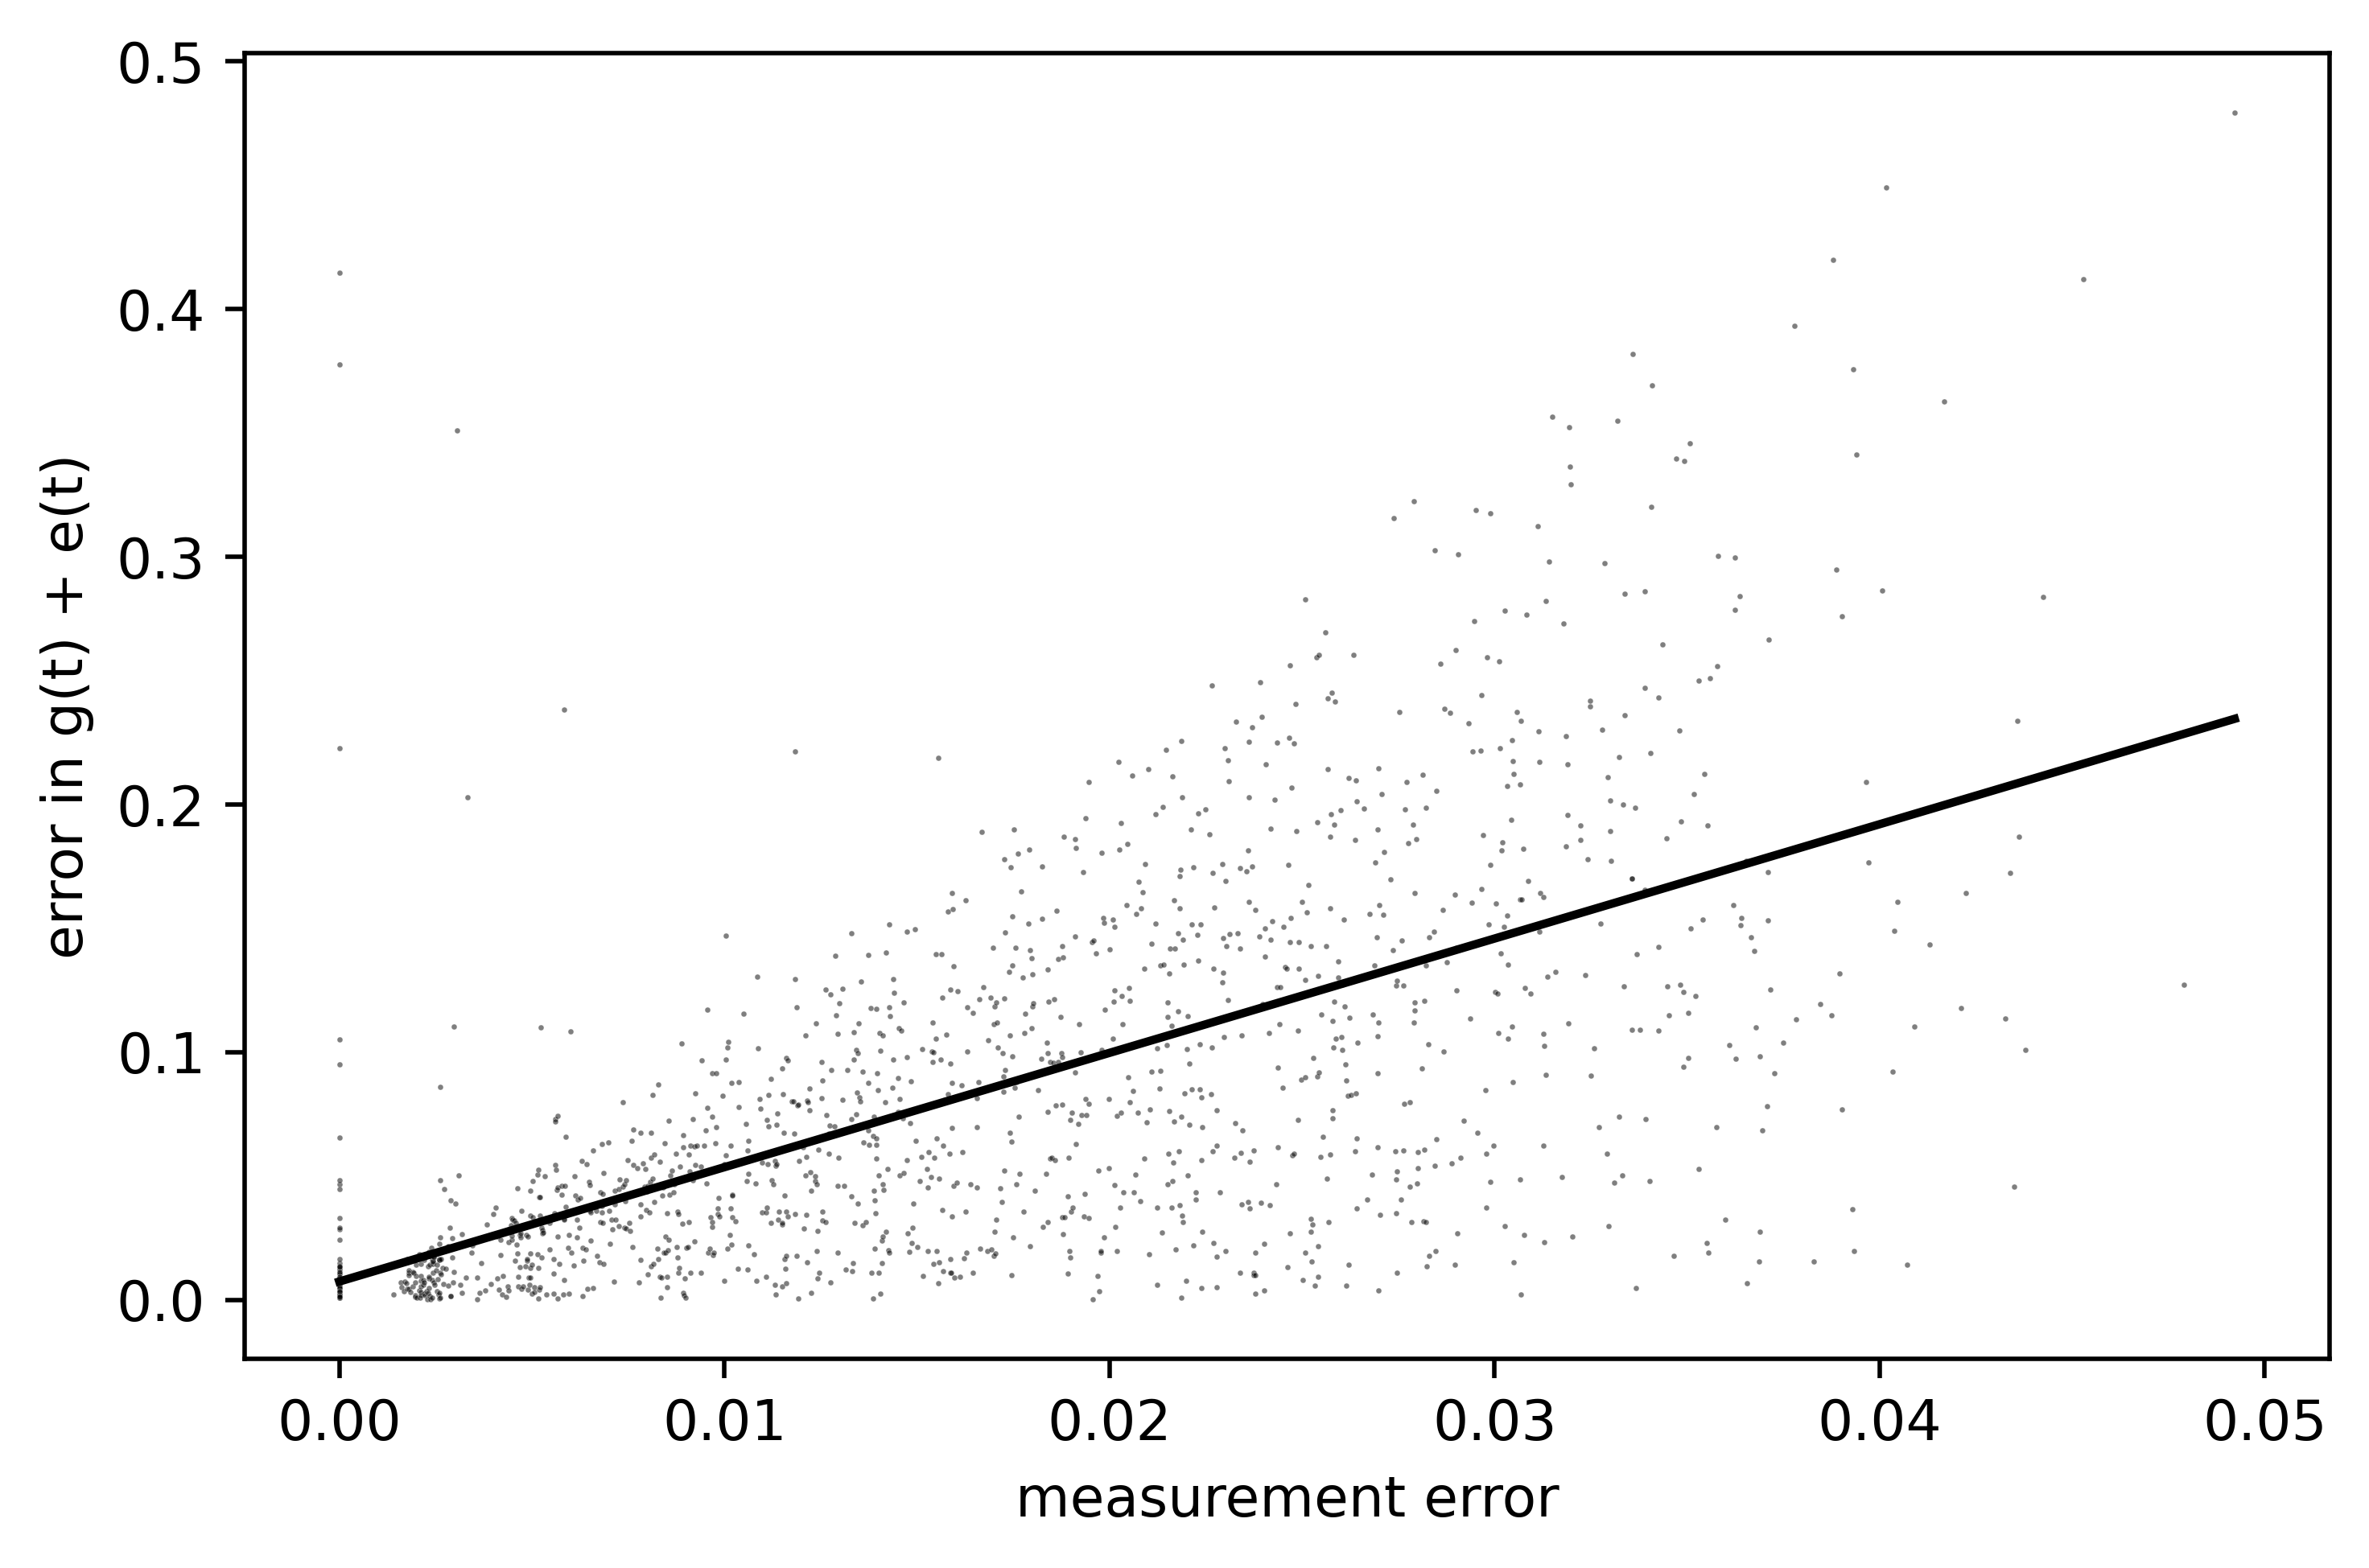

In [7]:
palette = {"err_total":"black"}
#palette = {"error in acetyl-CoA":"green"}
models = {}
#sb.lineplot(data=plt_dict,x="measurement error",y="error in g(t)",hue="method",palette=palette)
for error,color in palette.items():
    filt = plt_dict[plt_dict["method"] == "SISA"]
    #sb.regplot(data=filt,x="measurement error",y=error, ci=0,scatter_kws={"s": .1,"alpha":1.0},color=color,label=error)
    sb.scatterplot(data=filt,x="measurement error",y=error, s = 1,alpha=0.5,color=color)#,label=error)
    linReg = LinearRegression()
    linReg.fit(filt["measurement error"].values.reshape(-1,1),filt[error].values)
    #z = lowess(filt[error].values, filt["measurement error"].values,is_sorted=False)
    #pred = interp1d(z[:,0],z[:,1])(filt["measurement error"].values)
    pred = linReg.predict(filt["measurement error"].values.reshape(-1,1))
    r2 = r2_score(filt[error].values,pred)
    plt.plot(filt["measurement error"].values,pred,color=color)
    models[error] = interp1d(filt["measurement error"].values,pred,fill_value="extrapolate")
    print(error,r2)
    
plt.ylabel("error in g(t) + e(t)")
plt.tight_layout()
plt.savefig("../figures_presentations/noise_g_t_scatter_stearate.png")
#plt.legend()


In [8]:
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/desi/12C/"
[peaklist,msis] = pkl.load(open(datadir + "processed_data.pkl","rb"))

In [9]:
msi = msis[list(msis.keys())[0]]

In [10]:
inds = -1
targ = "C18H36O2"
for index,row in peaklist.iterrows():
    if row["formula"] == targ:
        inds = row["inds"]
        break
inds

[271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289]

In [11]:
#calculation labeling pattern images and save result
goodInds = [x for x in range(len(msi.data_tensor)) if x not in [17]]
iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor[inds])

In [12]:
patterns = []
for row in range(iso_tensor.shape[1]):
    for col in range(iso_tensor.shape[2]):
        if msi.imageBoundary[row,col] > 0.5:
            patterns.append(iso_tensor[:,row,col])
print(len(patterns))

22899


In [13]:
truePattern = isa_func(1.0,0,0,1.0,0,0,1.0,0.0,0.0)
print(truePattern)

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


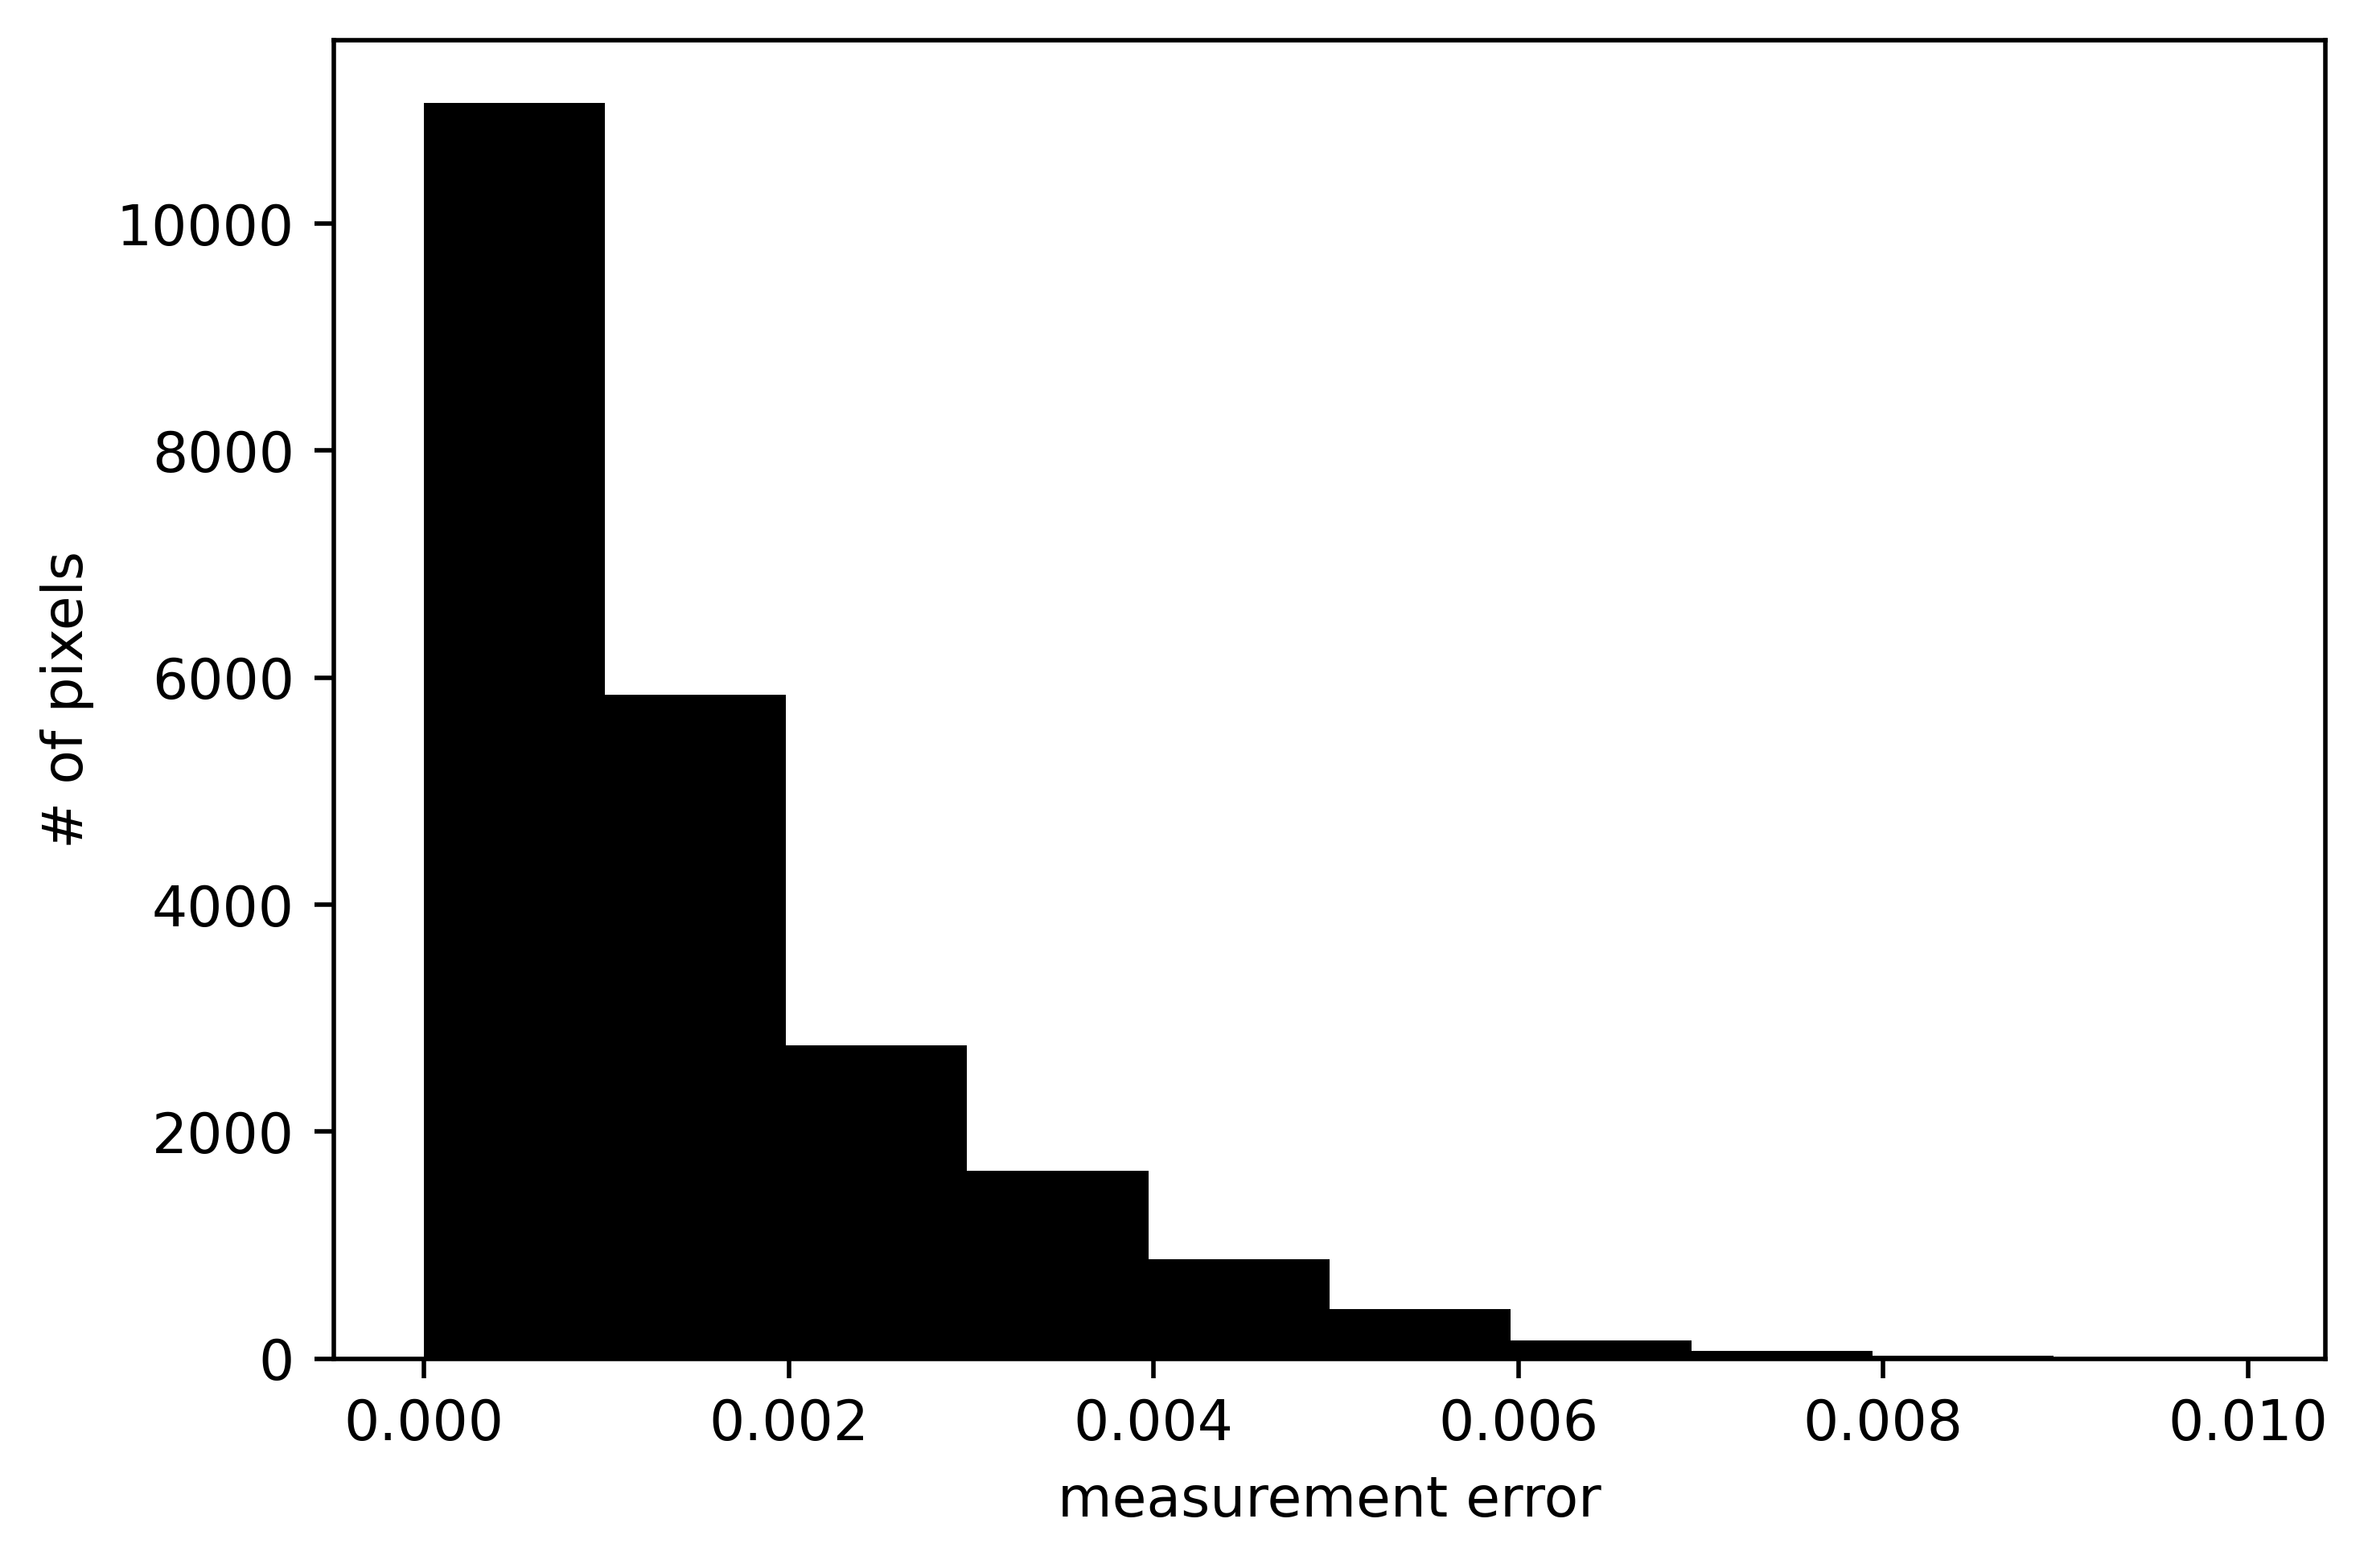

In [14]:
errs = []
for pattern in patterns:
    err_measure = np.mean([np.abs(x-y) for x,y in zip(pattern,truePattern)])
    errs.append(err_measure)
plt.hist(errs,color="black")
plt.xlabel("measurement error")
plt.ylabel("# of pixels")
plt.tight_layout()
plt.savefig("../figures_presentations/measurement_error_hist_stearate.png")

Text(0, 0.5, '# of pixels')

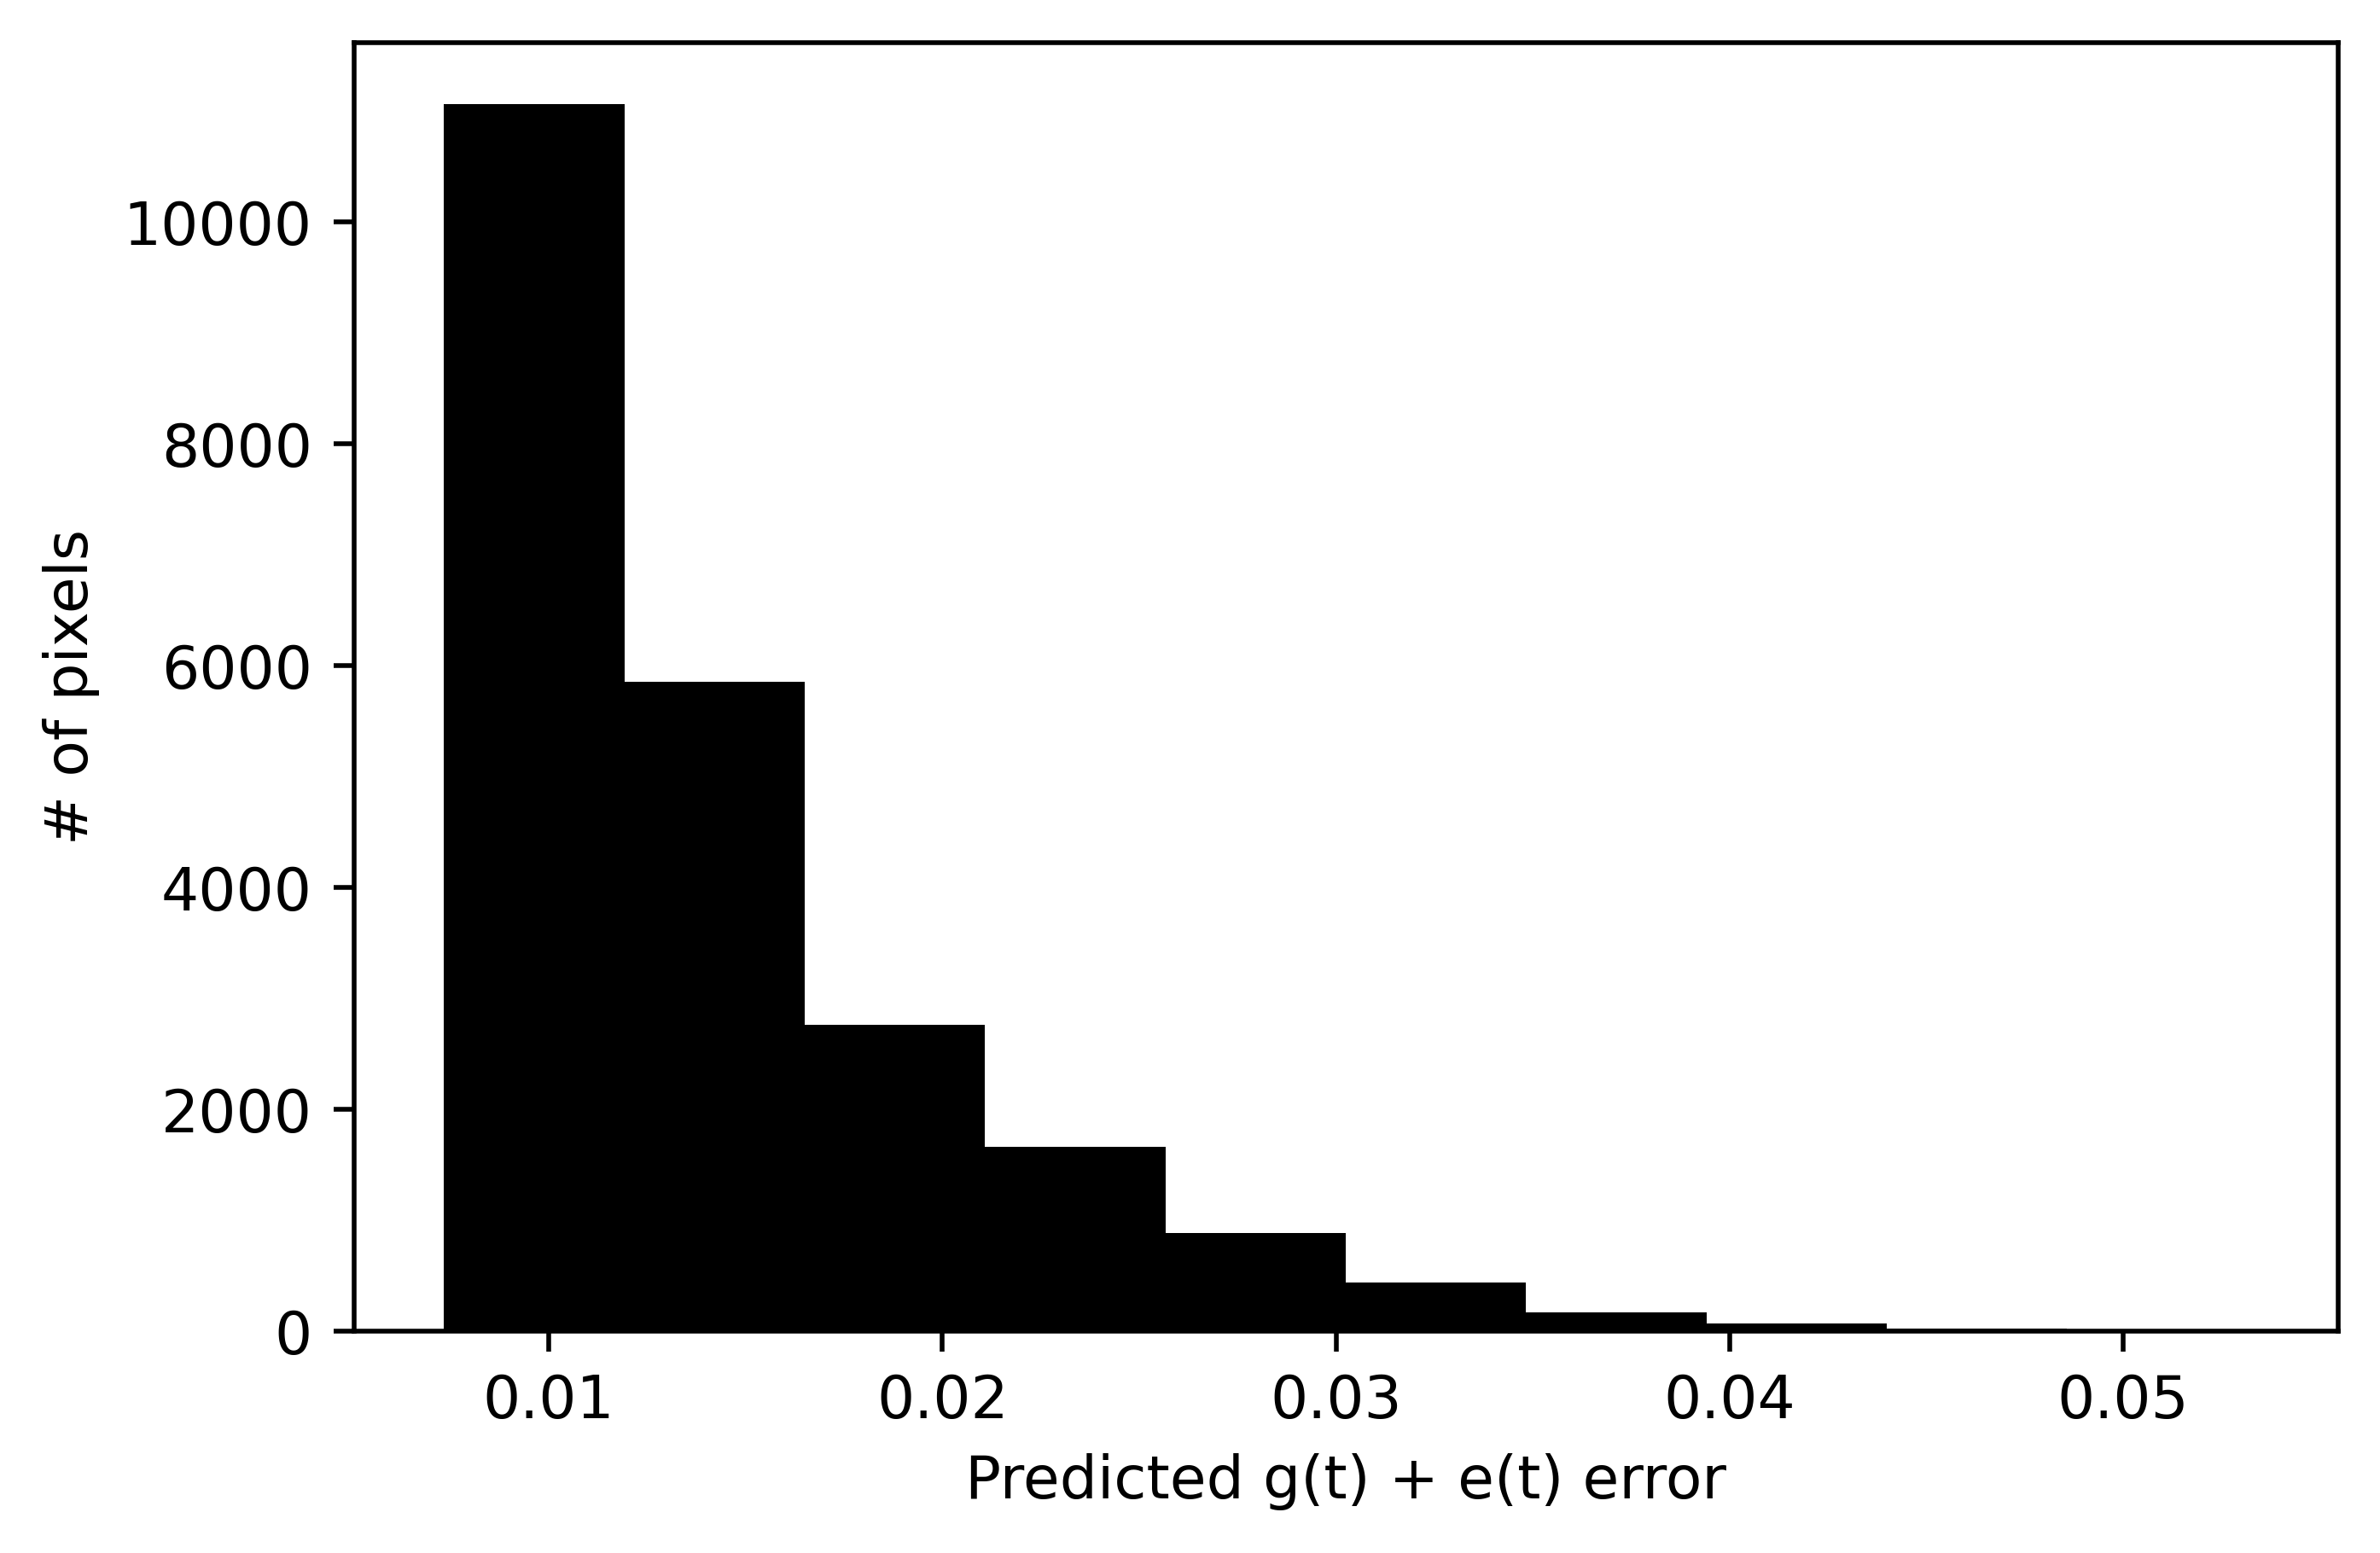

In [15]:
gerrs = []
xerrs = []
for err in errs:
    gerrs.append(models["err_total"](err).tolist())

plt.hist(gerrs,color="black")
plt.xlabel("Predicted g(t) + e(t) error")
plt.ylabel("# of pixels")

In [16]:
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/desi/13C/"
[peaklist,msis,fluxImages] = pkl.load(open(datadir + "processed_data.pkl","rb"))

In [17]:
key = "20221107_mt_tumor_brain4-4_13B_13C_20um_70-560mz Analyte 1_1_recal.imzML"

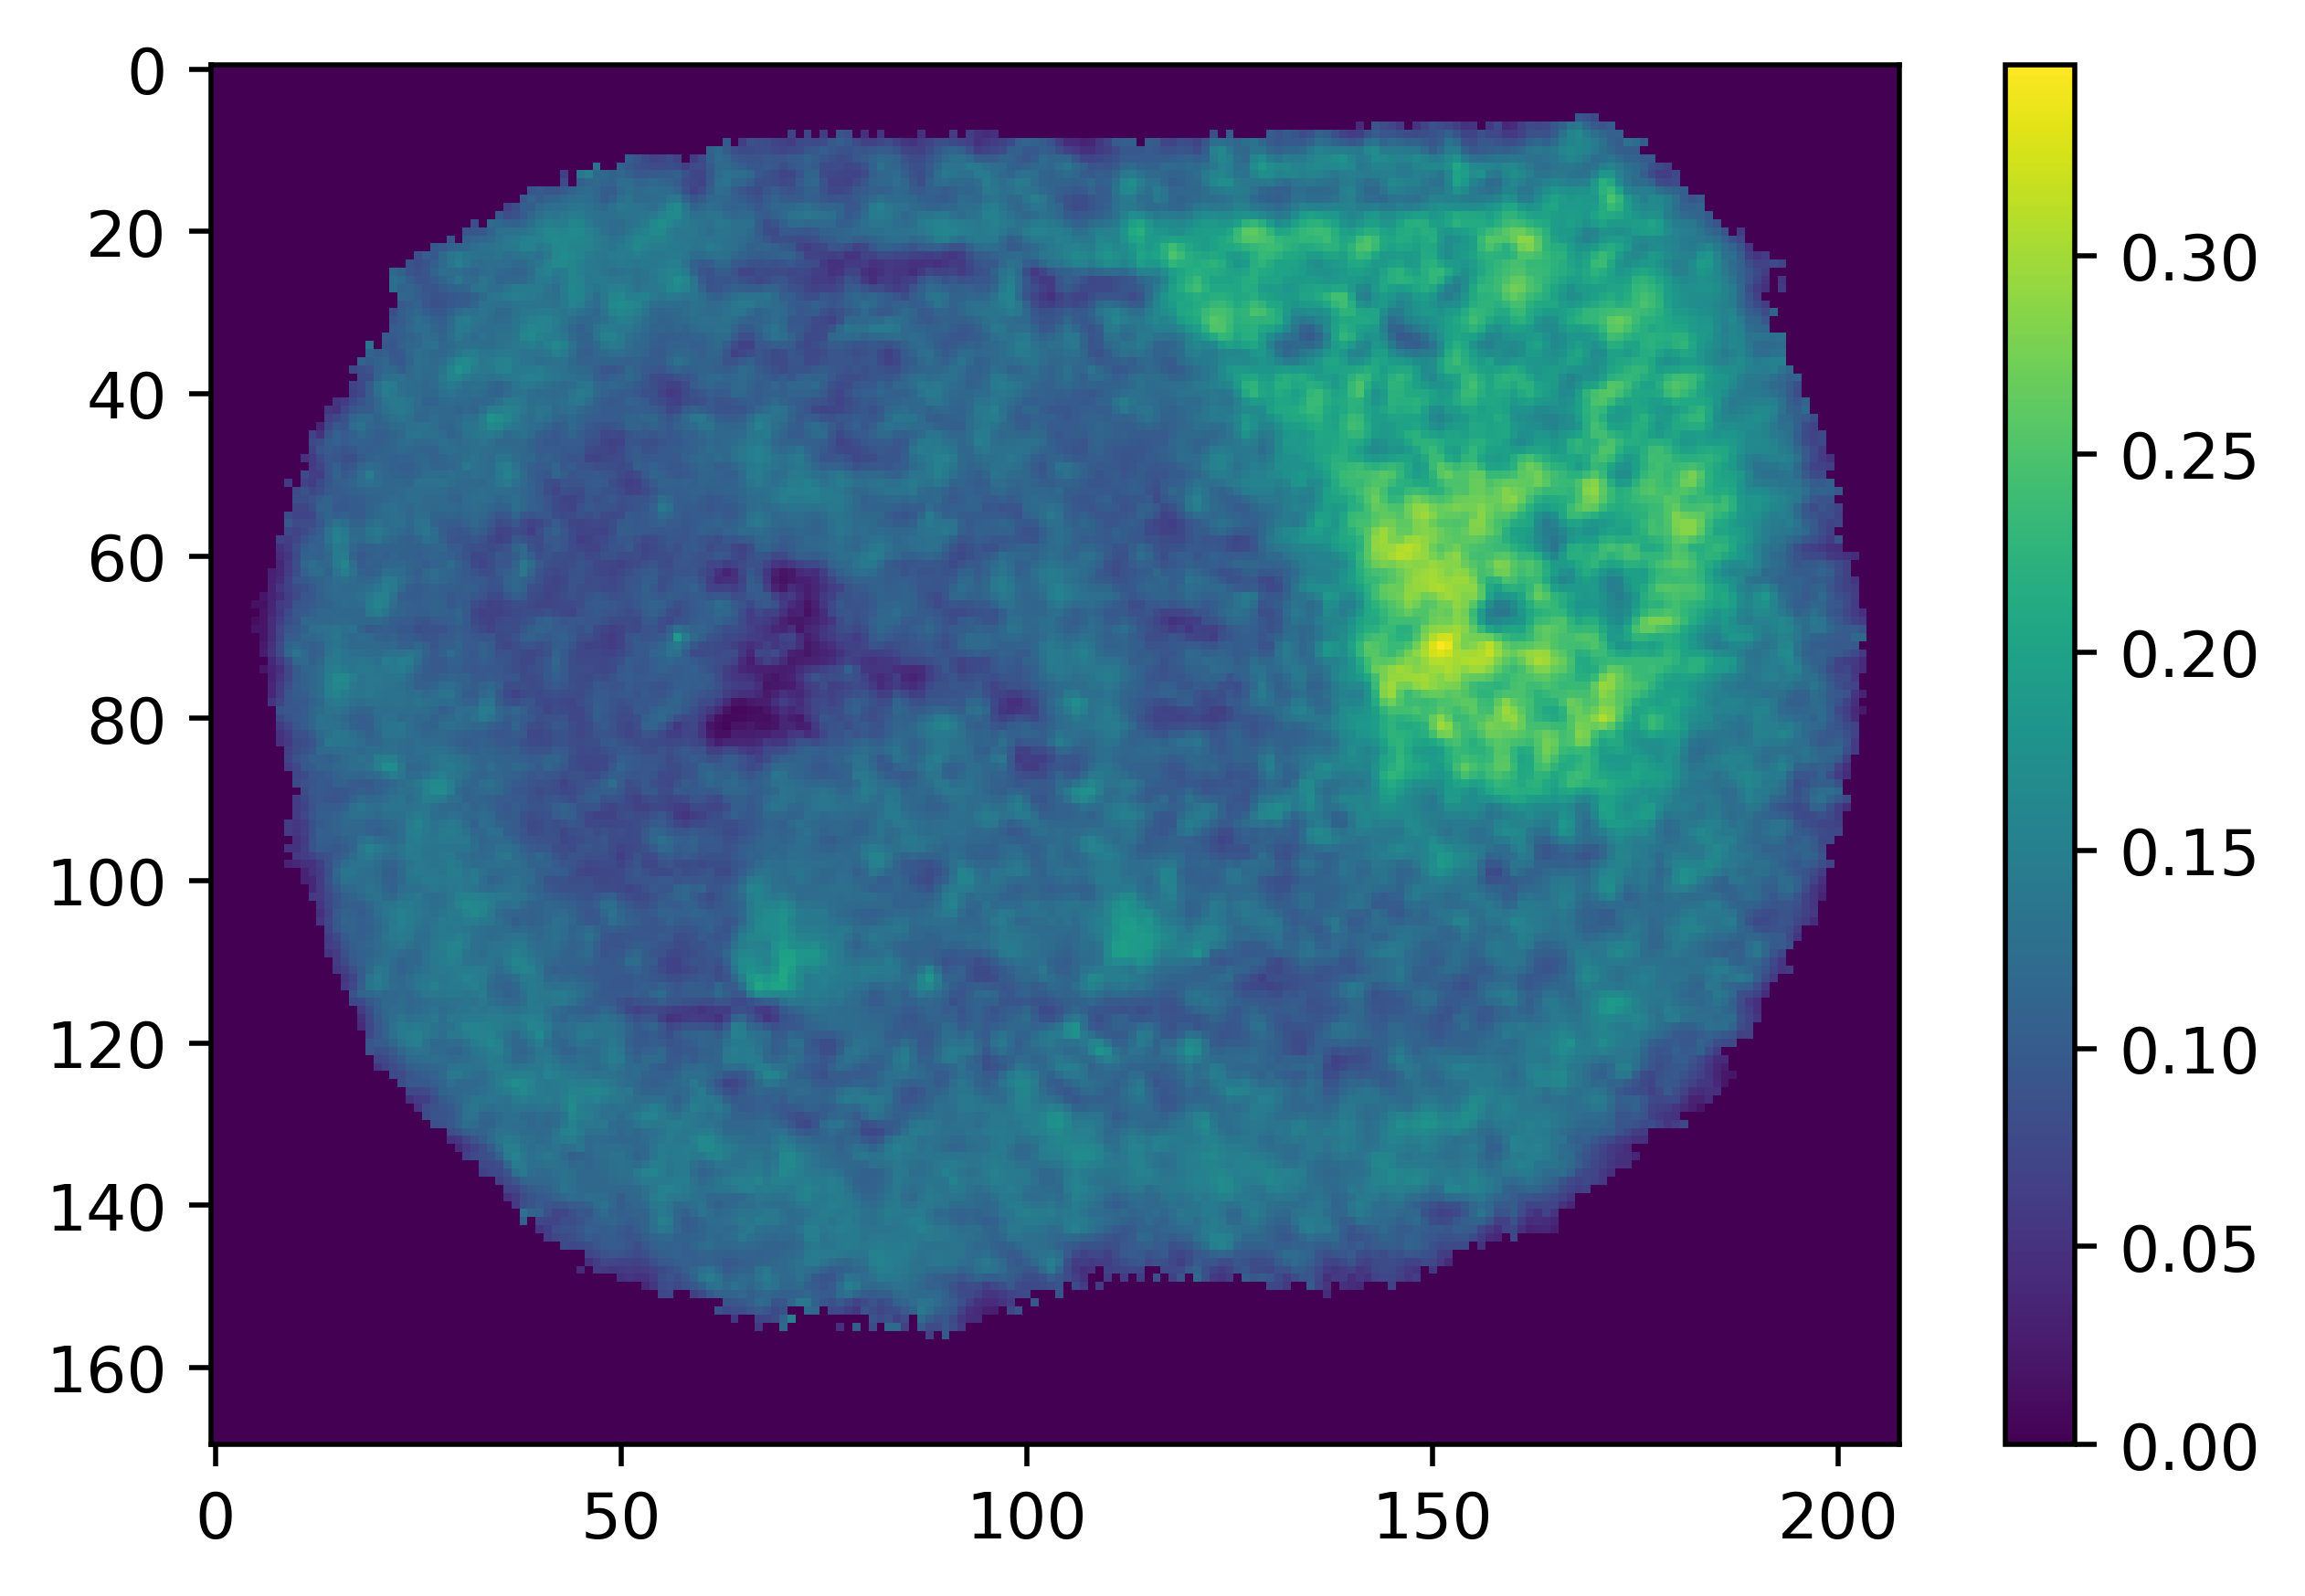

In [18]:
fluxImage = fluxImages[key]["stearate"]["g+e"]
plt.imshow(fluxImage)
plt.colorbar()

In [19]:
vals = fluxImage[msis[key].imageBoundary > 0.5].flatten()

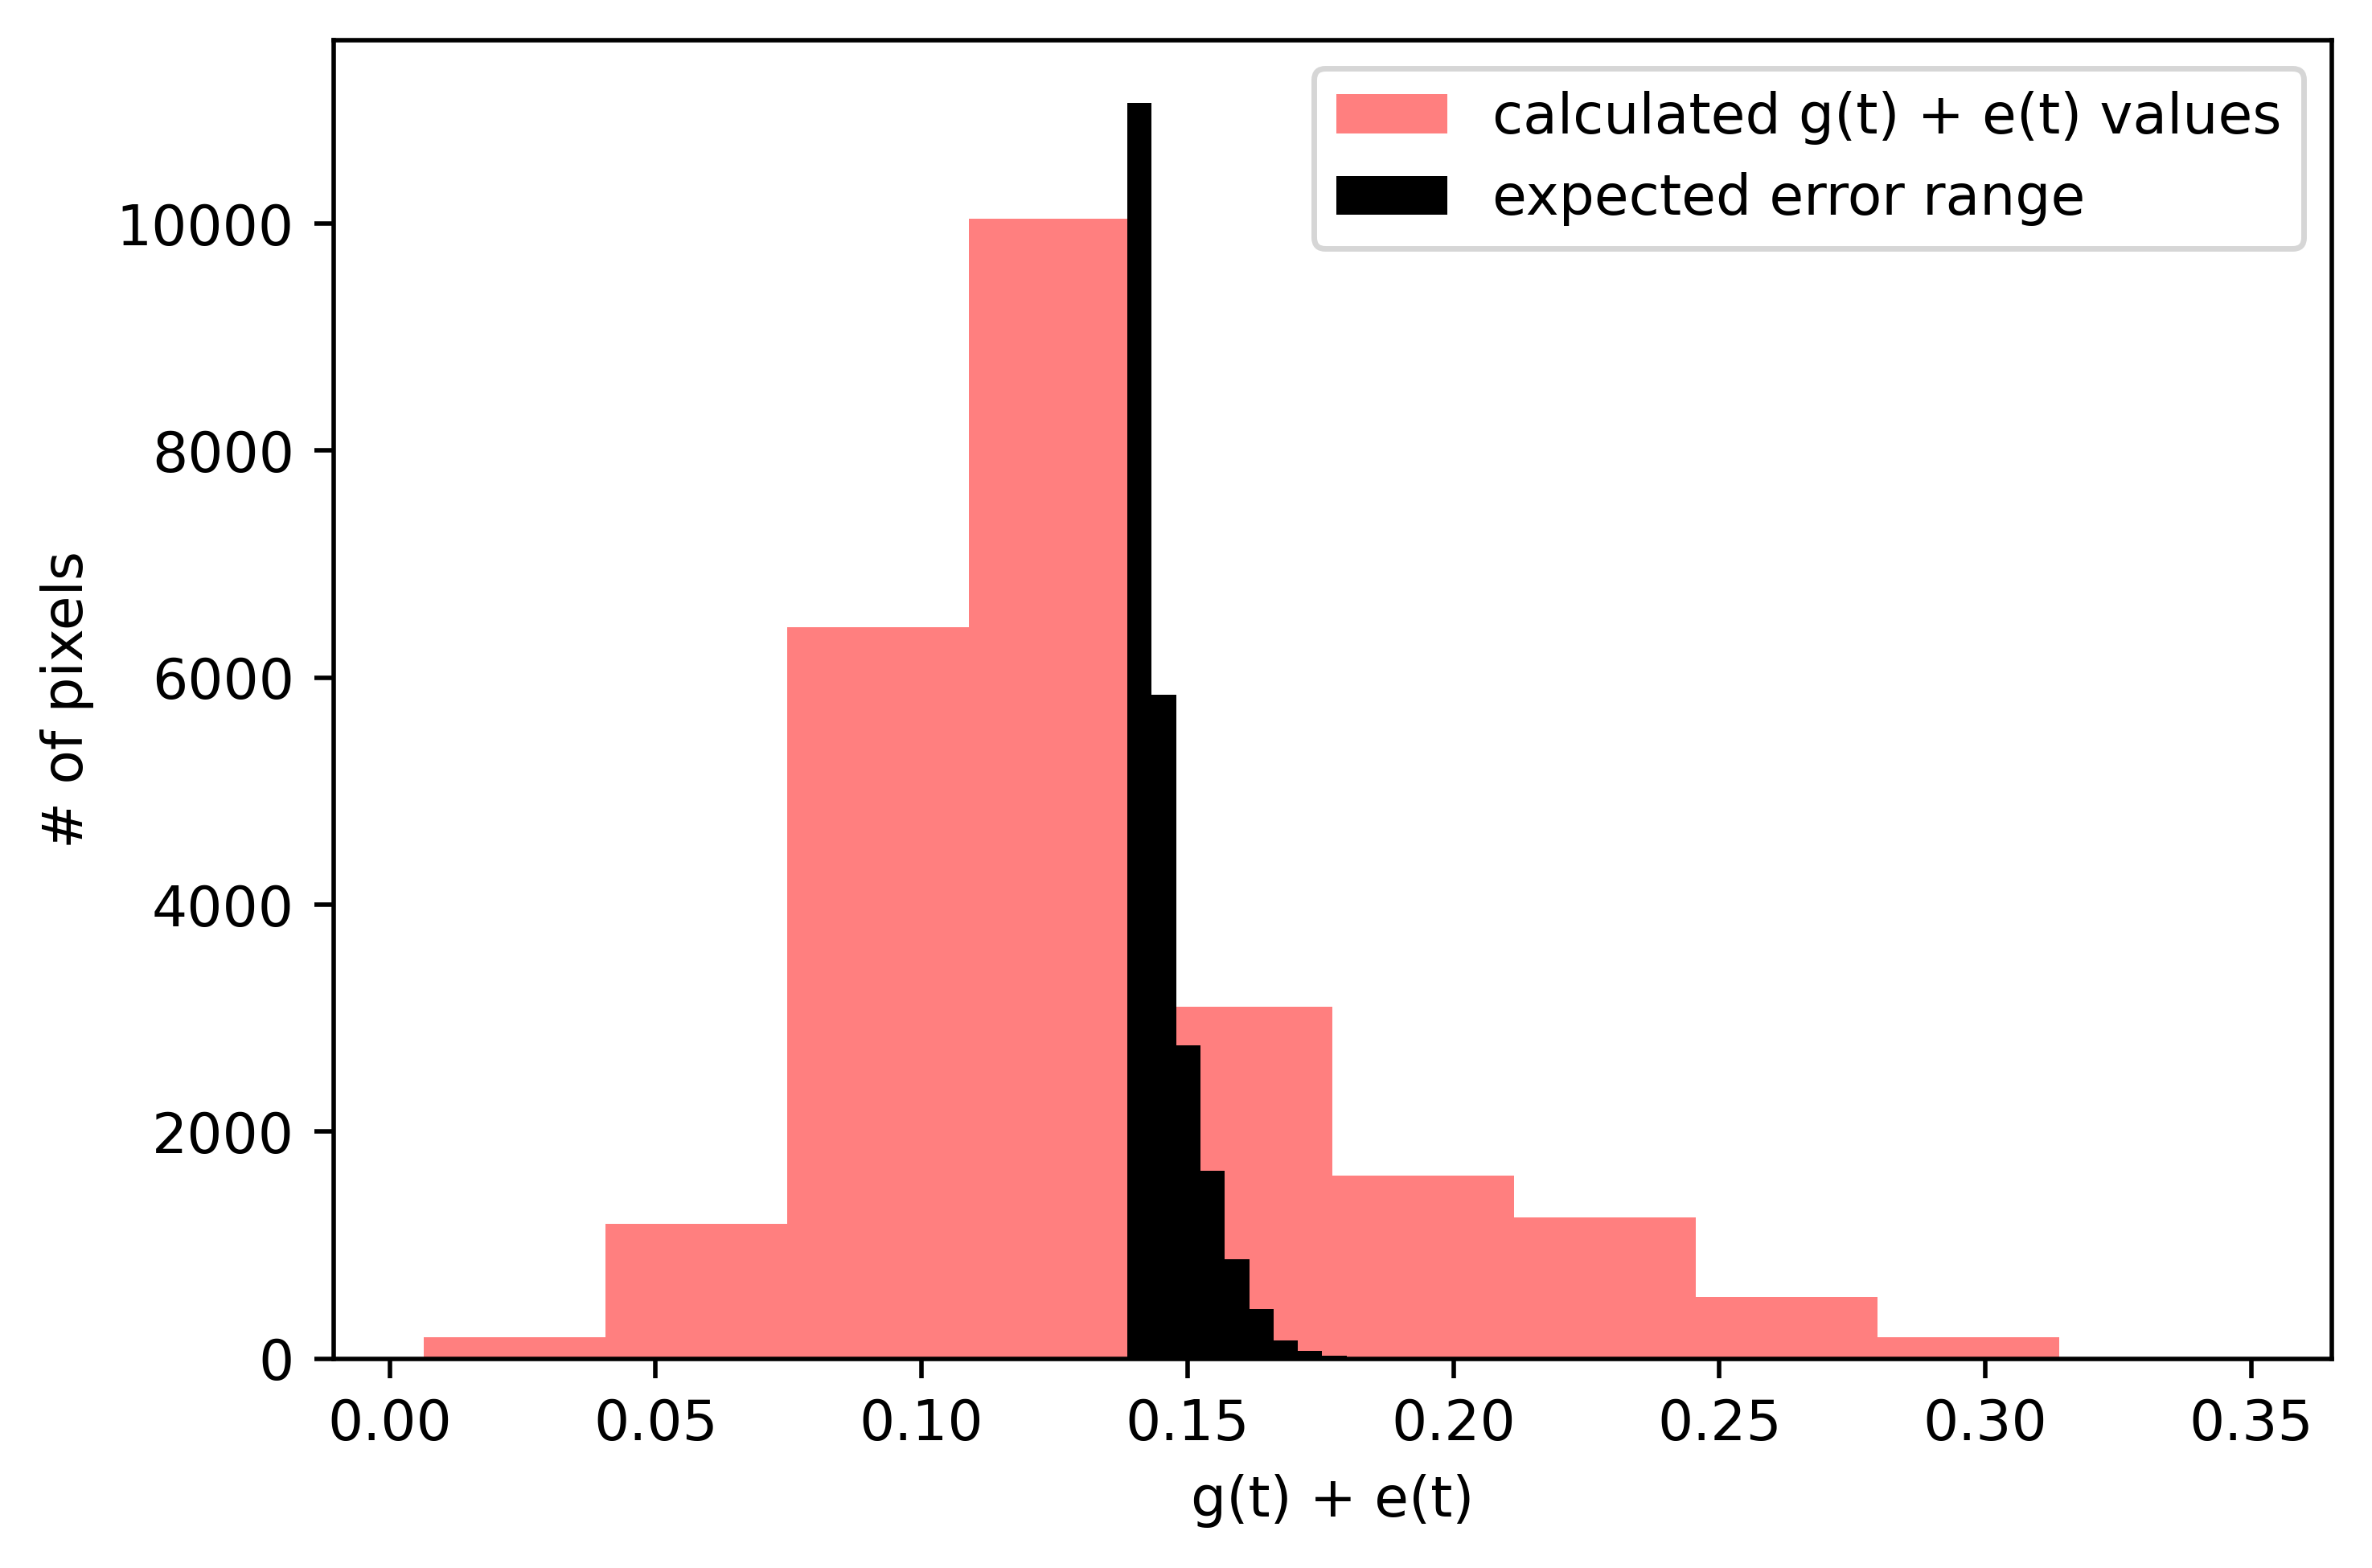

In [20]:
gerrs_shifted = gerrs + np.mean(vals)
plt.hist(vals,color="red",alpha=0.5,label="calculated g(t) + e(t) values")
plt.hist(gerrs_shifted,color="black",alpha=1.0,label="expected error range")
plt.xlabel("g(t) + e(t)")
plt.ylabel("# of pixels")
plt.legend()
plt.tight_layout()
plt.savefig("../figures_presentations/hist_overlay_stearate.png")